In [27]:
import time

import torch.nn as nn
import albumentations as A

from torchvision.ops import clip_boxes_to_image
from torchvision.transforms.functional import to_pil_image
import albumentations.pytorch.transforms as A_transform
from torch.utils.data import DataLoader
from PIL import Image, ImageDraw

import conf as cfg

from custom_dataset import CustomDataset
from utils import *
from model import *

import warnings
warnings.filterwarnings("ignore")

### 데이터셋 준비

In [2]:
img_width = 640
img_height = 480
voc_dir = r'C:\Users\junju\PycharmProjects\dataset\voc\VOCdevkit\VOC2007'
name2idx = {"pad": -1, "car": 0, "chair": 1}
idx2name = {v:k for k, v in name2idx.items()}

A_Resize = A.Compose([
    A.Resize(img_height, img_width),
    A_transform.ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

train_dataset = CustomDataset(dataset_dir=voc_dir, name2idx=name2idx, dataset_div='trainval',
                                       apply_transform=A_Resize)

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=False)

2it [00:00, 85.28it/s]


### 이미지 및 바운딩 박스 시각화

In [3]:
for imgs, boxes, labels in train_dataloader:
    break

model = torchvision.models.resnet50(pretrained=True)

req_layers = list(model.children())[:8]
backbone = nn.Sequential(*req_layers)

dummy_input = torch.randn((1, 3, img_height, img_width))

out = backbone(dummy_input)

out_c, out_h, out_w = out.size(dim=1), out.size(dim=2), out.size(dim=3)
out_c, out_h, out_w

(2048, 15, 20)

[335.35999298095703, 268.8000011444092, 413.4400177001953, 432.63999938964844] (340.35999298095703, 273.8000011444092)
[209.92000579833984, 336.64000511169434, 322.5600051879883, 474.8799991607666] (214.92000579833984, 341.64000511169434)
[5.120000243186951, 311.04000091552734, 84.47999954223633, 477.44001388549805] (10.12000024318695, 316.04000091552734)
[307.1999931335449, 247.0400047302246, 376.3199996948242, 381.43999099731445] (312.1999931335449, 252.0400047302246)
[353.27999114990234, 236.8000030517578, 398.0799865722656, 280.31999588012695] (358.27999114990234, 241.8000030517578)


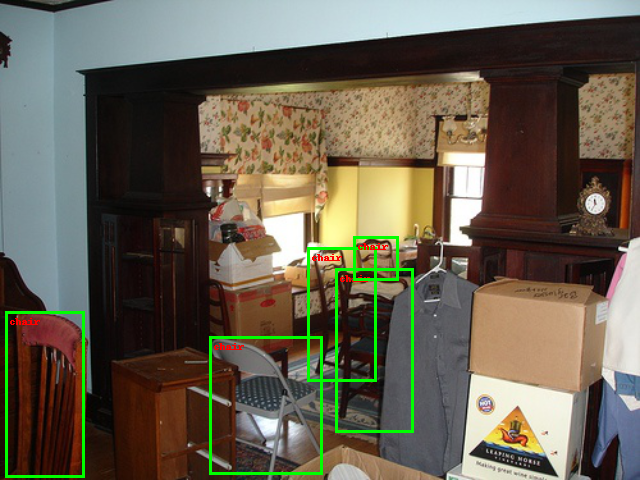

In [4]:
gt_class_1 = labels[0].long()
gt_class_1 = [idx2name[idx.item()] for idx in gt_class_1]

img = to_pil_image(imgs[0])
draw = ImageDraw.Draw(img)

for box, label in zip(boxes[0], gt_class_1):
    box = box.tolist()
    label_loc = (box[0] + 5, box[1] + 5)
    
    print(box, label_loc)
    
    draw.rectangle(box, outline=(0, 255, 0), width=3)
    draw.text(label_loc, label, (255, 0, 0))

img

In [5]:
width_scale_factor = img_width // out_w
height_scale_factor = img_height // out_h
height_scale_factor, width_scale_factor

(32, 32)

In [6]:
img_size = (img_height, img_width)
out_size = (out_h, out_w)
n_classes = len(name2idx) - 1
roi_size = (7, 7)

model = TwoStageDetector(img_size, out_size, out_c, n_classes, roi_size).to(cfg.DEVICE)

In [7]:
learning_rate = 0.0001
n_epochs = 1000
    
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for i in range(n_epochs):
    
    model.train()
    for train_batch_idx, (train_img_batch, train_gt_bboxes_batch, train_gt_classes_batch) in enumerate(train_dataloader):
        
        start_time = time.time()
        train_img_batch = train_img_batch.float().to(cfg.DEVICE)
        train_gt_bboxes_batch = train_gt_bboxes_batch.float().to(cfg.DEVICE)
        train_gt_classes_batch = train_gt_classes_batch.float().to(cfg.DEVICE)
        
        train_loss = model(train_img_batch, train_gt_bboxes_batch, train_gt_classes_batch)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        print(f"Epochs: {i + 1}\tBatch:{train_batch_idx + 1}/{len(train_dataloader)}\tTime: {np.round(time.time() - start_time, 2)}\tTrain Loss: {train_loss.item():.2f}", end='\r')
        
    print()

Epochs: 1	Batch:1/1	Time: 3.33	Train Loss: 84.43
Epochs: 2	Batch:1/1	Time: 0.94	Train Loss: 143.71
Epochs: 3	Batch:1/1	Time: 0.88	Train Loss: 112.07
Epochs: 4	Batch:1/1	Time: 0.86	Train Loss: 53.05
Epochs: 5	Batch:1/1	Time: 0.87	Train Loss: 43.03
Epochs: 6	Batch:1/1	Time: 0.95	Train Loss: 40.38
Epochs: 7	Batch:1/1	Time: 1.09	Train Loss: 39.49
Epochs: 8	Batch:1/1	Time: 0.99	Train Loss: 39.92
Epochs: 9	Batch:1/1	Time: 0.86	Train Loss: 40.77
Epochs: 10	Batch:1/1	Time: 0.96	Train Loss: 42.77
Epochs: 11	Batch:1/1	Time: 0.99	Train Loss: 36.28
Epochs: 12	Batch:1/1	Time: 1.09	Train Loss: 34.27
Epochs: 13	Batch:1/1	Time: 0.96	Train Loss: 31.32
Epochs: 14	Batch:1/1	Time: 0.9	Train Loss: 31.25
Epochs: 15	Batch:1/1	Time: 0.9	Train Loss: 30.10
Epochs: 16	Batch:1/1	Time: 0.99	Train Loss: 29.95
Epochs: 17	Batch:1/1	Time: 1.04	Train Loss: 30.15
Epochs: 18	Batch:1/1	Time: 0.97	Train Loss: 29.23
Epochs: 19	Batch:1/1	Time: 0.9	Train Loss: 28.92
Epochs: 20	Batch:1/1	Time: 0.94	Train Loss: 28.23
Epochs: 21

### Inference

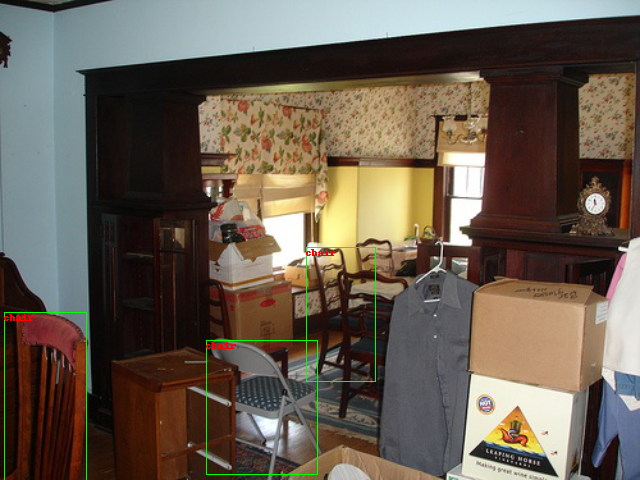

In [26]:
for img_batch, gt_bboxes, gt_classes in train_dataloader:
    img_data_all = img_batch.float().to('cuda')

model.eval()
proposals_final, _, classes_final = model.inference(img_data_all, conf_thresh=0.95, nms_thresh=0.05)

prop_proj = convert_bboxes_scale(proposals_final[0].to('cpu'), width_scale_factor, height_scale_factor, mode='real')

classes_pred = [idx2name[cls] for cls in classes_final[0].tolist()]

img = to_pil_image(img_batch[0], mode='RGB')
draw = ImageDraw.Draw(img)

for bbox_pred, label in zip(prop_proj, classes_pred):
    bbox_pred = bbox_pred.tolist()
    
    draw.rectangle(bbox_pred, outline=(0, 255, 0))
    draw.text(bbox_pred[:2], label, (255, 0, 0))

img